# **Загрузка библиотек**

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_theme()

# Новая логика через классы

# Функции

In [13]:
def find_P_b_matrix(phase: float, period: int): #  пока оставить -----
    P_b = np.zeros((3, 3))
    cos_vals = np.cos(phase * np.arange(int(period) + 1))
    sin_vals = np.sin(phase * np.arange(int(period) + 1))

    P_b[0, 0] = np.sum(cos_vals**2)
    P_b[0, 1] = np.sum(cos_vals * sin_vals)
    P_b[0, 2] = np.sum(cos_vals)
    P_b[1, 0] = P_b[0, 1]
    P_b[1, 1] = np.sum(sin_vals**2)
    P_b[1, 2] = np.sum(sin_vals)
    P_b[2, 0] = P_b[0, 2]
    P_b[2, 1] = P_b[1, 2]
    P_b[2, 2] = period + 1

    return P_b

In [14]:
def zero_crossing(data: np.ndarray, harmonic_hf: float, offset: int, start_period: float):
    n = offset
    iteration = 0
    period = start_period

    amplitudes = []
    phases = []
    other = []

    while n < (data.shape[0] - np.floor(period) - 1):

        phase = 2 * np.pi / period * harmonic_hf # связано со временеи обората, длинна сгустка - bunch ## похоже на фазу 

        period = int(period)

        harmonics_vector = np.zeros(3) # матрица гармоник от 0 до period 
        harmonics_vector[0] = np.sum(data[n:n + period + 1] * np.cos(phase * np.arange(period + 1)))
        harmonics_vector[1] = np.sum(data[n:n + period + 1] * np.sin(phase * np.arange(period + 1)))
        harmonics_vector[2] = np.sum(data[n:n + period + 1])

        P = find_P_b_matrix(phase, period)
        A = np.linalg.inv(P) @ harmonics_vector.T # ----

        amplitudes.append(np.sqrt(A[0]**2 + A[1]**2)) # амплитуда 
        phases.append(n + (1 / phase * np.arctan2(A[0], -A[1]))) # фаза 
        other.append(A[2]) # ----

        n = int(np.floor(phases[iteration] + period)) # перечет офсета 

        period = 1 / 10 * (phases[iteration] - phases[iteration-10]) if iteration > 12 else period # перечсет периода для окна 

        iteration += 1

    return np.array(amplitudes), np.array(phases), np.array(other)

# **Acceleration in Booster measured with FCT 1-1**

## Booster parameters

In [15]:
mass_proton = 938.256 * 10**6 # масса покоя протона 
charge_electron  = 1.6021 * 10**(-19) # заряд электрона в Кл
speed_of_light = 2.997925 * 10**10

In [16]:
charge_number = 28 # зарядовое число
booster_perimeter = 21096 # периметр бустера в мм
delta_time = (50 * 10e5)**(-1)

## Чтение данных

In [17]:
data_length = 7 * 32 * 128 * 1024 + 1

In [18]:
filepath = {'FCT': r'../data/booster_acceleration/1/27_01_23_booster_fct_1.bin',
            'RF': r'../data/booster_acceleration/1/27_01_23_booster_rf_1.bin'}

In [19]:
signal = {'FCT': np.fromfile(filepath['FCT'], dtype='int16')[:data_length],
          'RF': np.fromfile(filepath['RF'], dtype='int16')[:data_length]}

In [20]:
offset = {'FCT': 45, 'RF': 10} # сдвиг начала 
last_period_number = 1500 # сдвиг конца
injection_period = 425.067 # период на энжекции (период можно высчетать как в прошлом файле)

In [21]:
injection_period_range = np.arange(injection_period, dtype=int)   
signal_first_slice = {}
signal_last_slice = {}

for x in 'FCT', 'RF':
    signal_first_slice[x] = signal[x][injection_period_range + offset[x]]
    signal_last_slice[x] = signal[x][(offset[x] + injection_period_range + int(offset[x] * injection_period))]

## Графики

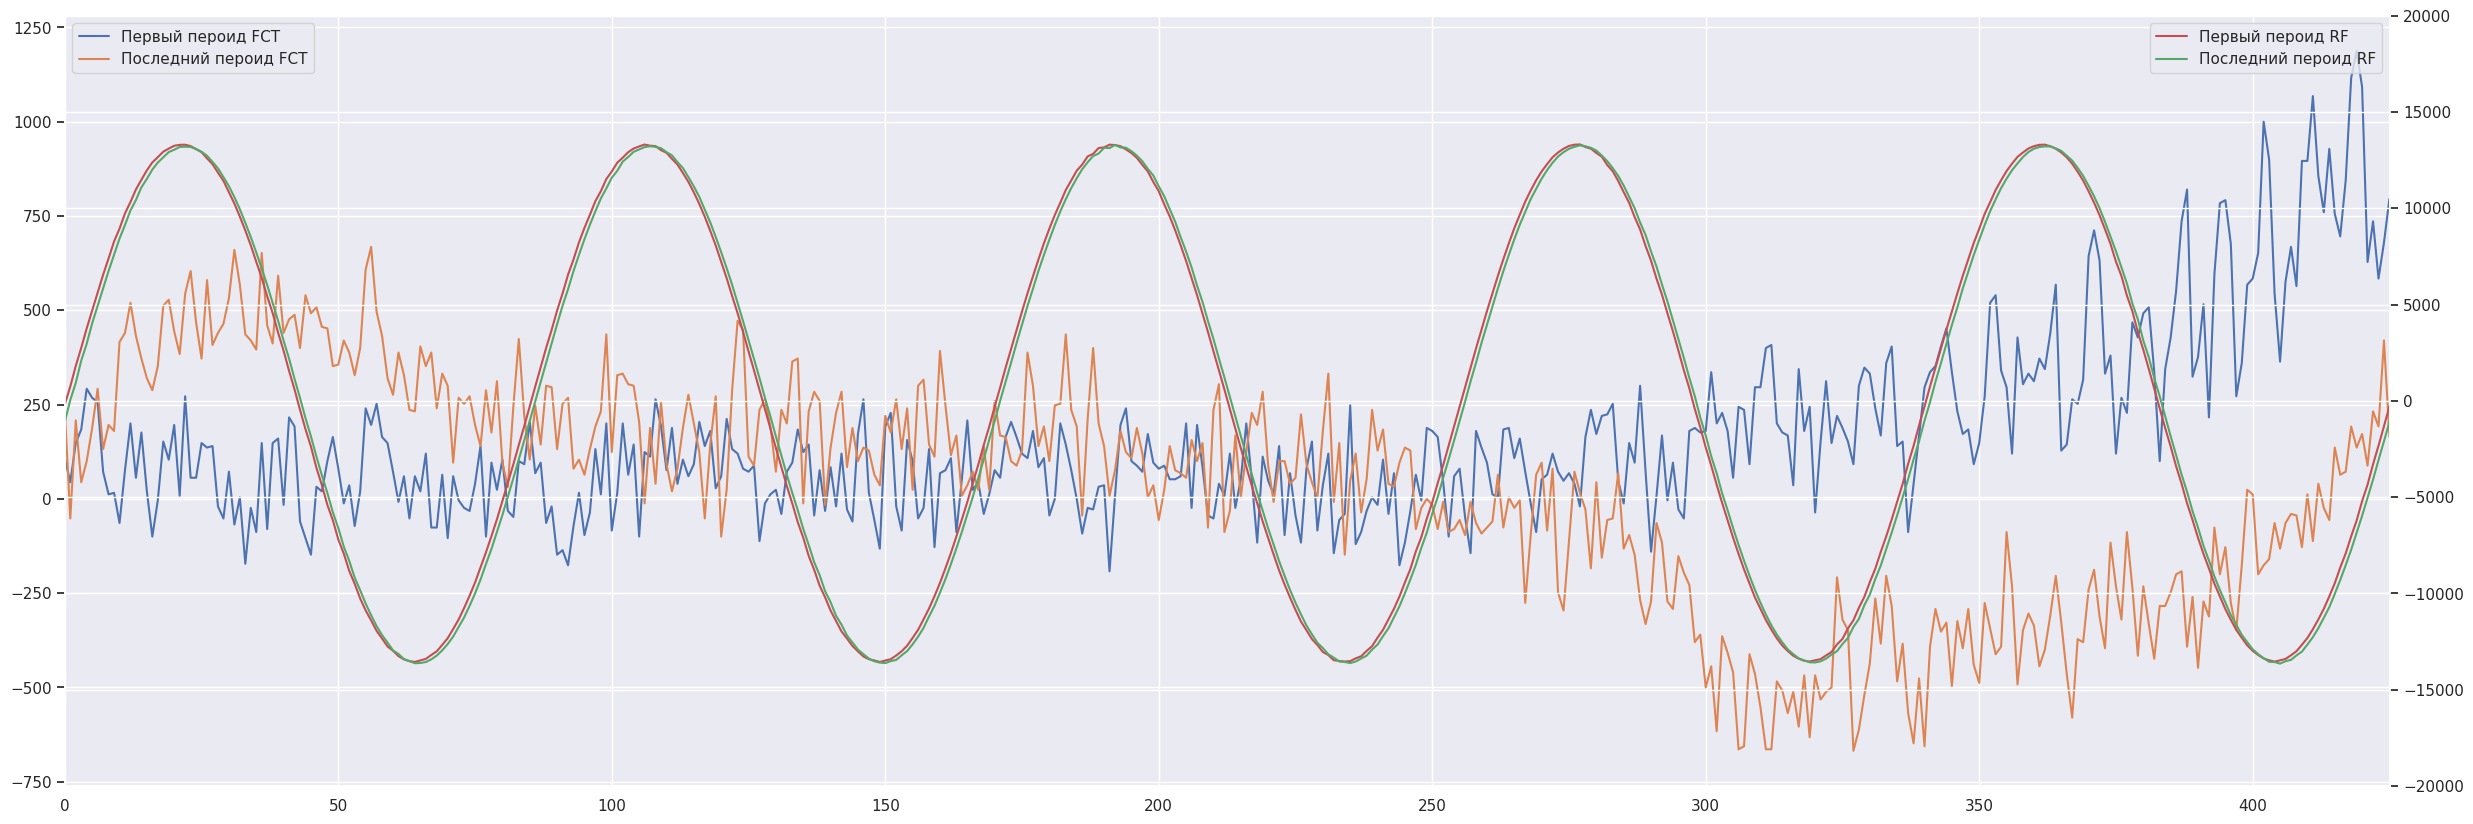

In [22]:
fig = plt.figure(figsize=(30, 10))

plt.plot(injection_period_range, signal_first_slice['FCT'], label='Первый пероид FCT')
plt.plot(injection_period_range, signal_last_slice['FCT'], label='Последний пероид FCT')
plt.legend()

plt.twinx()

plt.plot(injection_period_range, signal_first_slice['RF'], color='r', label='Первый пероид RF')
plt.plot(injection_period_range, signal_last_slice['RF'], color='g', label='Последний пероид RF')
plt.legend()

plt.xlim([0, injection_period])
plt.ylim([-2*10**(4), 2*10**4]);

## signal_RF_generator data fiffing to the harmonic signal_RF_generator waveform from injection to intermidate flat top

In [23]:
harmonic_hf = 5 # назвать лучше h - гармоника ВЧ

In [24]:
amplitudes, phases, other = zero_crossing(signal['RF'], harmonic_hf, offset['RF'], injection_period)

In [25]:
rounded_phases = np.int32(phases[1:])

In [26]:
phase_difference_rf = np.diff(phases) # разность фаз ## изменение фазы ВЧ
beta = booster_perimeter / (speed_of_light * delta_time * phase_difference_rf) # Лоренс фактор 
gamma = 1 / np.sqrt(1 - beta**2) # Лоренс фактор 
total_energy = (gamma - 1) * mass_proton # Полная энергия 

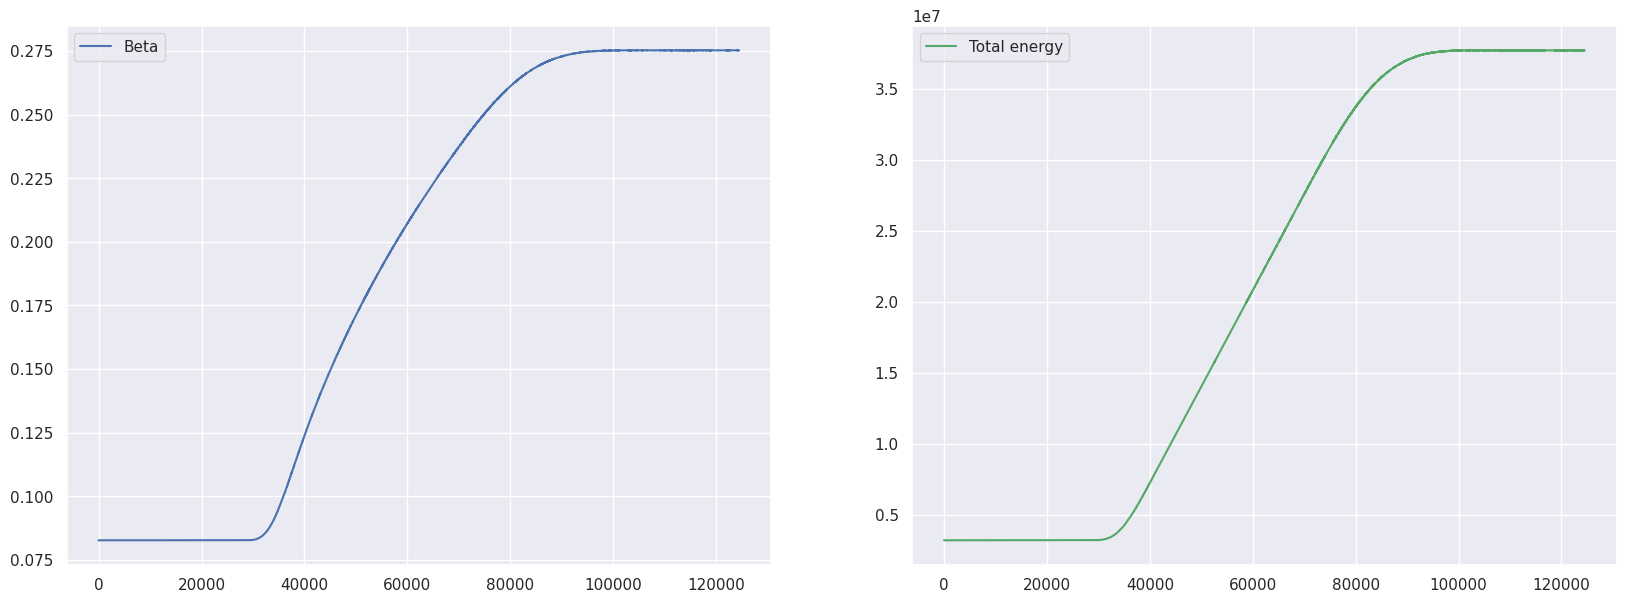

In [27]:
fig = plt.figure(figsize=(20, 7))

plt.subplot(1,2,1)
plt.plot(np.arange(len(beta)), beta, label='Beta')
plt.legend()

plt.subplot(1,2,2)
plt.plot(np.arange(len(beta)), total_energy, color='g', label='Total energy')
plt.legend();

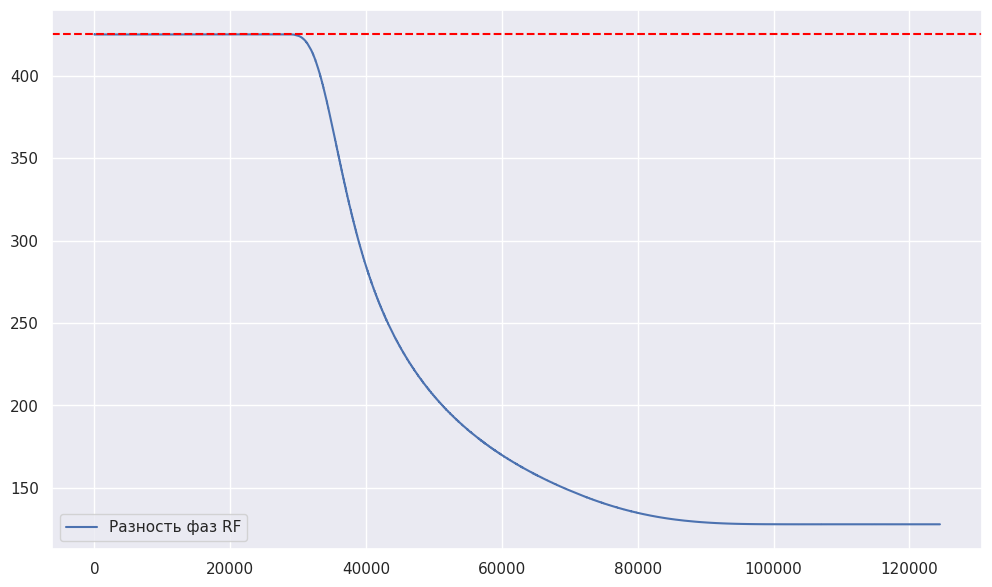

In [28]:
fig = plt.figure(figsize=(12, 7))
plt.plot(np.arange(len(phase_difference_rf)), phase_difference_rf, label='Разность фаз RF')
plt.axhline(y=injection_period, color='red', ls='--')
plt.legend();

In [29]:
number_window_samples = 70_000 # начало построения окна в отчетах для графика 
delta_iB = 10 # смещение для графика 

/tmp/ipykernel_27115/3099273646.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(6,1, window_samples // 10_000)


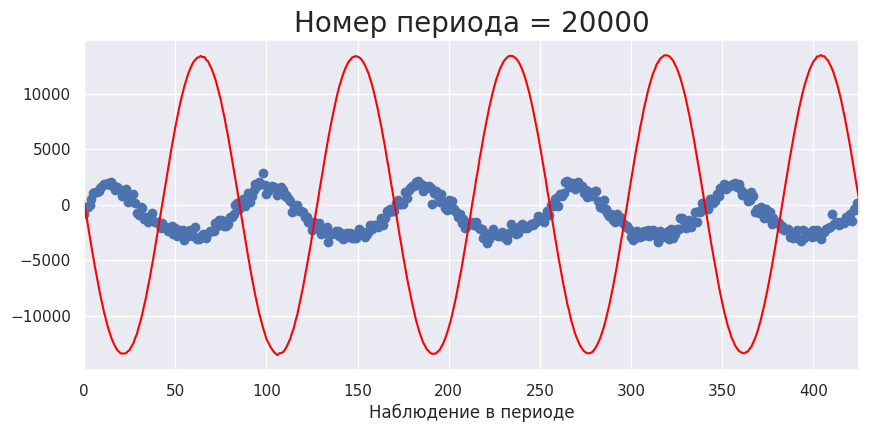

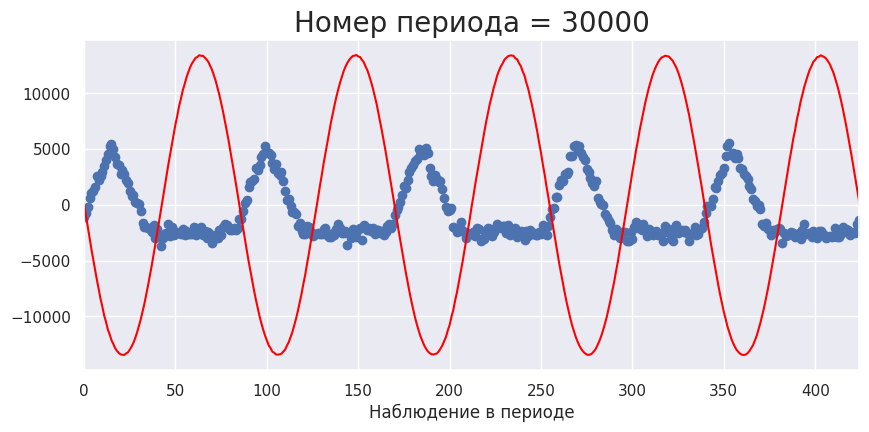

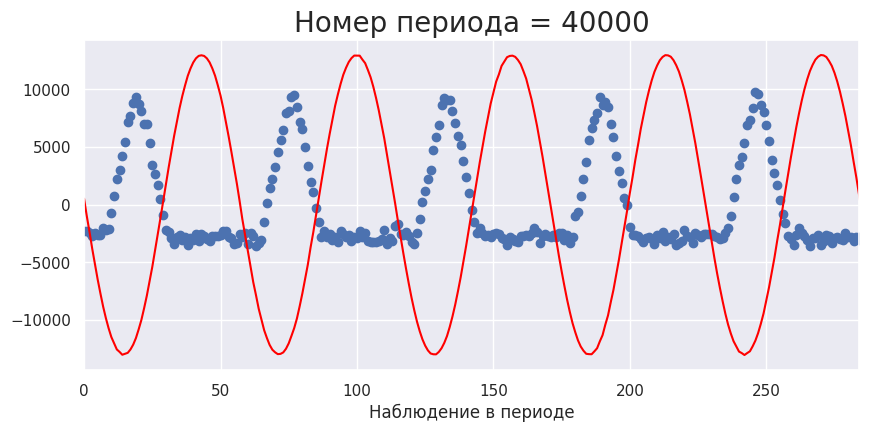

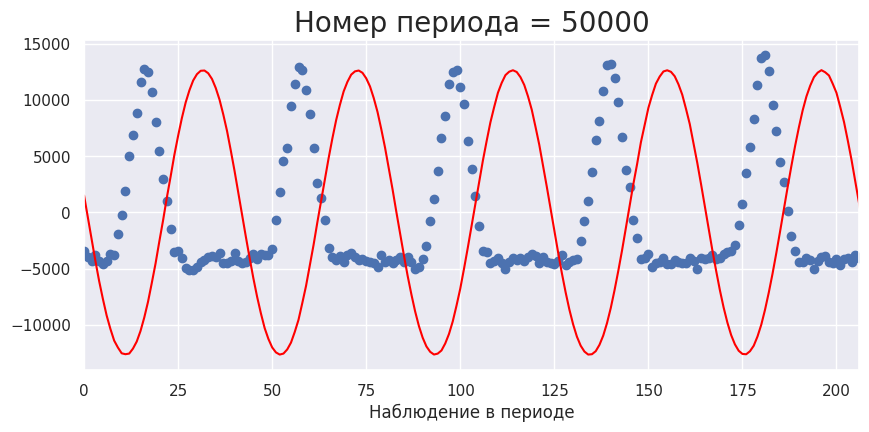

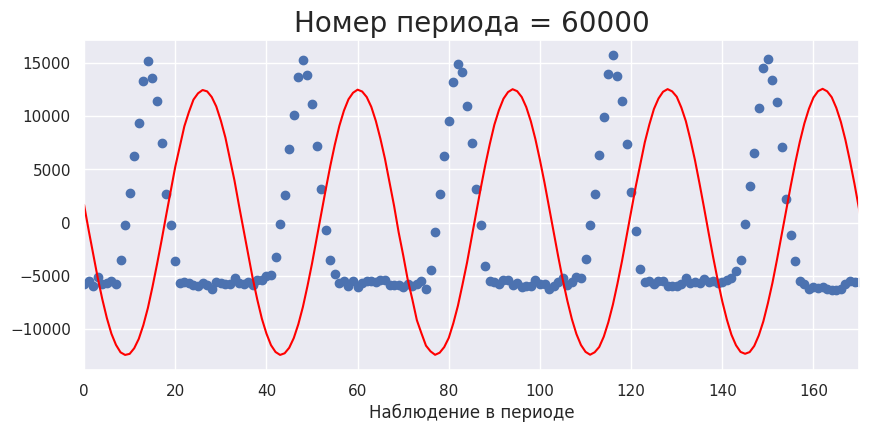

In [30]:
for window_samples in range(20_000, number_window_samples, 10_000):
    
    data_1 = signal['RF'][injection_period_range + rounded_phases[window_samples]] - other[window_samples]
    data_2 = 3 * signal['FCT'][injection_period_range + rounded_phases[window_samples] + delta_iB]

    plt.subplots(figsize=(10, 30))
    plt.subplot(6,1, window_samples // 10_000)
    
    plt.title(f'Номер периода = {window_samples}', fontsize=20)
    plt.plot(injection_period_range, data_1, color='red')
    plt.scatter(injection_period_range, data_2)
    plt.xlabel('Наблюдение в периоде')

    plt.xlim([0, rounded_phases[window_samples+1]-rounded_phases[window_samples]])

вопрос по поводу того, что фаза 10 к и 20 к отличается от основного сигнала 

Text(0.5, 1.0, 'Нормированные амплитуды')

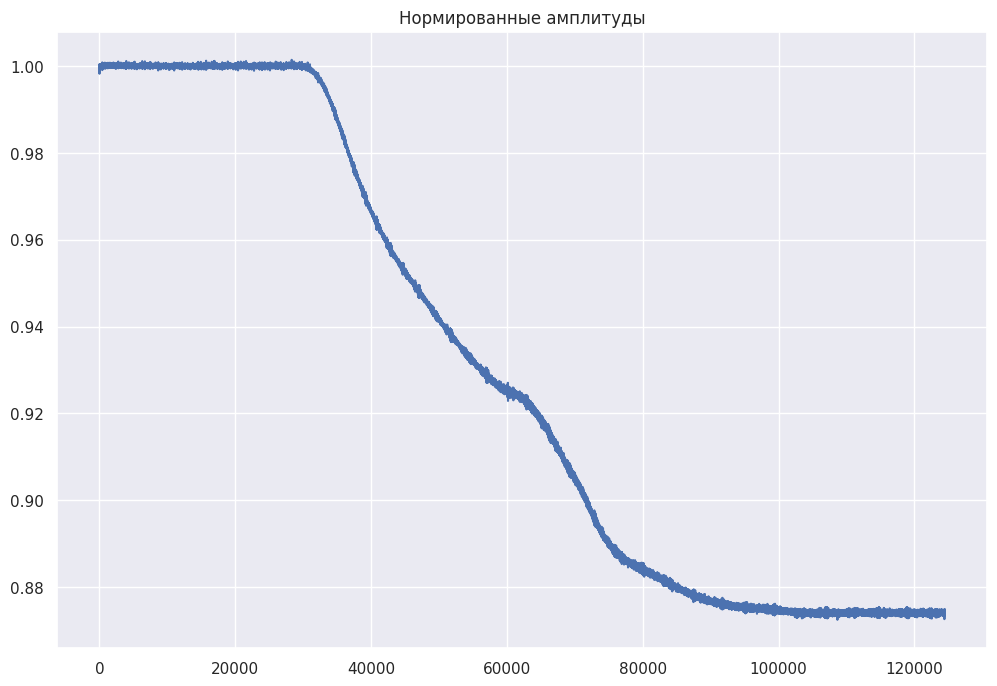

In [55]:
fig = plt.figure(figsize=(12, 8))

plt.plot(np.arange(len(amplitudes)), amplitudes/amplitudes[0]) # нормировка амплитуды
plt.title('Нормированные амплитуды');

In [32]:
def get_minimums_with_smoothing(signal, period_nodes, window_length): # сглаживание усреднием и поиск минимуна по усредненному сигналу
    result = np.zeros(len(period_nodes)-1)
    for i in range(len(period_nodes)-1):
        result[i] = np.convolve(signal[period_nodes[i]: period_nodes[i+1]], np.ones(window_length) / window_length, mode='valid').min()
    return result

In [44]:
phases_offset = 2
rounded_phases_with_offset = rounded_phases[phases_offset:]
signal_munimums = get_minimums_with_smoothing(signal['FCT'][delta_iB:], rounded_phases_with_offset, 13)

In [56]:
signal_munimums

array([-335.38461538, -406.15384615, -425.53846154, ..., -135.07692308,
       -157.53846154, -179.69230769])

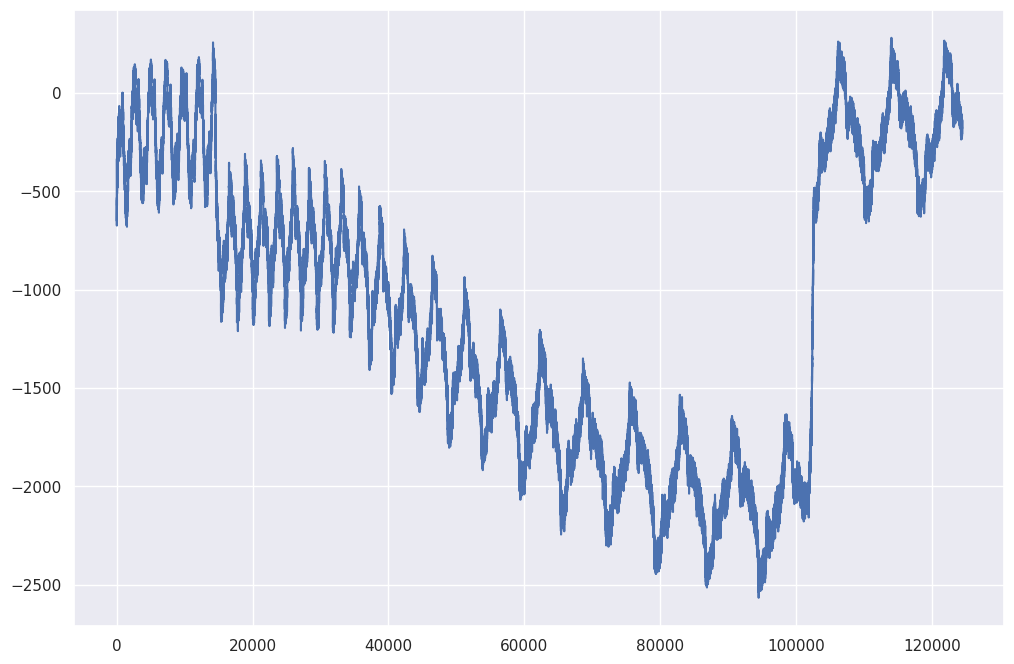

In [45]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(len(signal_munimums)), signal_munimums);

In [46]:
intensities = np.fromiter((8.6 * 10**(-5) * (10**(-3) / (5 * charge_number)) *\
        (delta_time / charge_electron) * np.sum(signal['FCT'][rounded_phases_with_offset[i] + delta_iB: rounded_phases_with_offset[i+1] + delta_iB + 1] - signal_munimums[i])
        for i in range(len(rounded_phases_with_offset)-1)), float) # интенсивность пучка в частицах

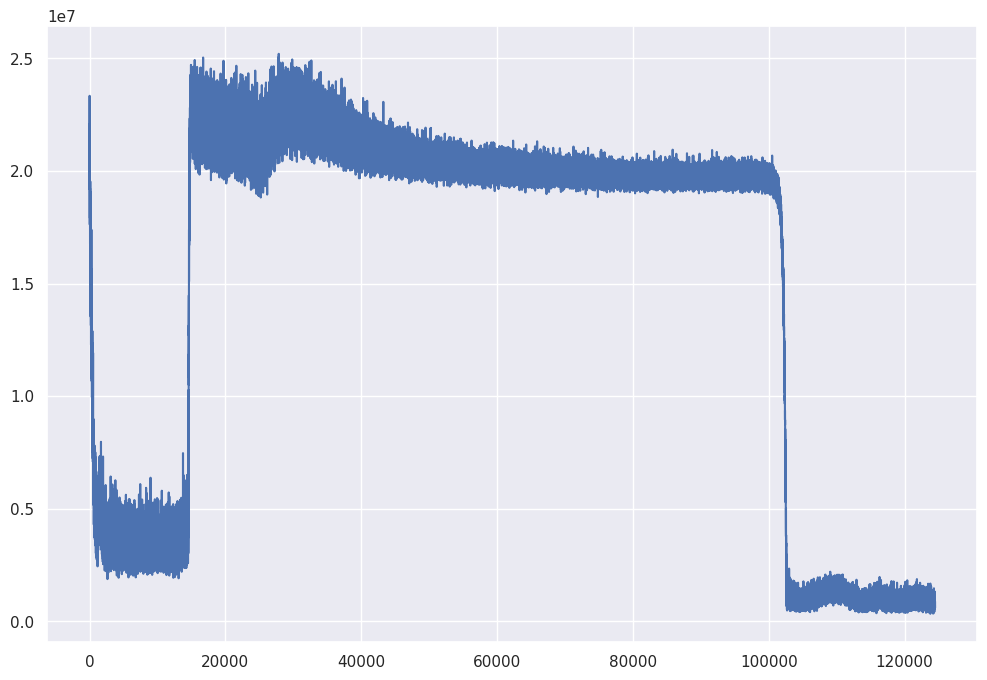

In [49]:
fig = plt.figure(figsize=(12, 8))
plt.plot(np.arange(len(intensities)), intensities);

In [51]:
phi = np.zeros(len(rounded_phases_with_offset)-1, dtype='float') # фаза в градусах 

for i in range(len(rounded_phases_with_offset)-1):
    up_sum = np.sum((signal['FCT'][rounded_phases_with_offset[i] + delta_iB: rounded_phases_with_offset[i+1] + delta_iB + 1] - signal_munimums[i])\
                    * (np.arange(rounded_phases_with_offset[i+1]-rounded_phases_with_offset[i]+1) + rounded_phases_with_offset[i] -\
                       (phases[phases_offset+i+2] + phases[phases_offset+i+1]) / 2))
    under_sum = np.sum(signal['FCT'][rounded_phases_with_offset[i] + delta_iB: rounded_phases_with_offset[i+1] + delta_iB + 1] - signal_munimums[i])
    phi[i] = 360 * harmonic_hf / (rounded_phases_with_offset[i+1]-rounded_phases_with_offset[i]) * (up_sum / under_sum) # коэффициент поправки для выравнивания сигналов относительно нуля

In [57]:
phi

array([-136.10190431, -123.85523948, -136.26961738, ...,   81.29707831,
        -55.82672351, -167.23262097])

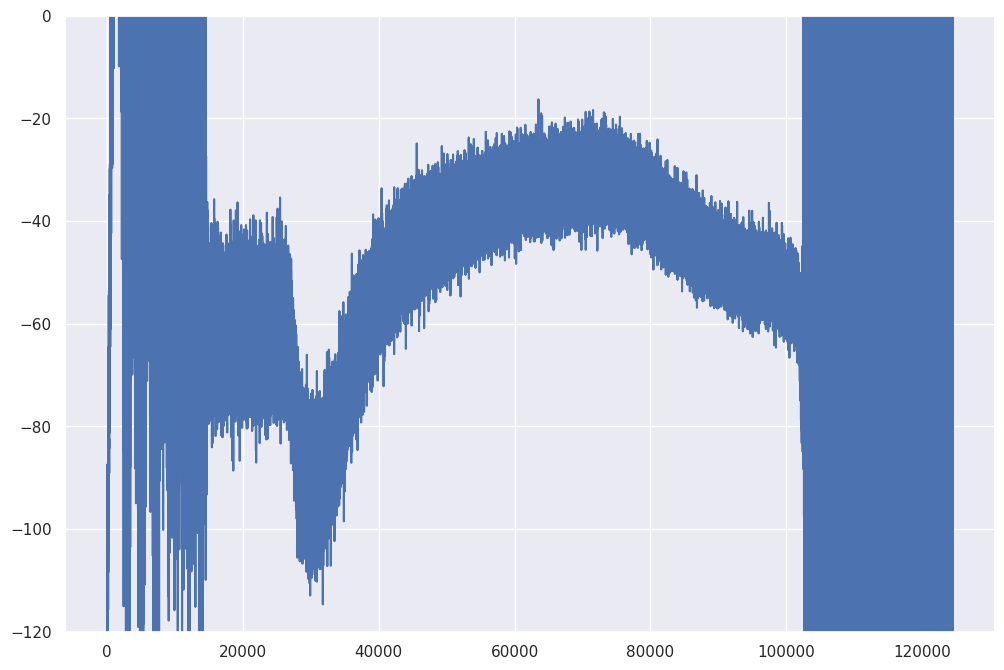

In [52]:
fig = plt.figure(figsize=(12, 8))
plt.plot(np.arange(len(phi)), phi)
plt.ylim([-120, 0]);

In [53]:
averaging_window = 20 # новое окно для усреднения 
phi_averaged = np.convolve(np.hstack((np.zeros(2), phi)), np.ones(averaging_window)/averaging_window, mode='valid')[::averaging_window][:-1]

In [58]:
phi_averaged

array([-1.06766199e+02, -1.11726322e+02, -1.06593955e+02, ...,
        3.12368782e+01,  2.15497155e+01,  1.11609559e-01])

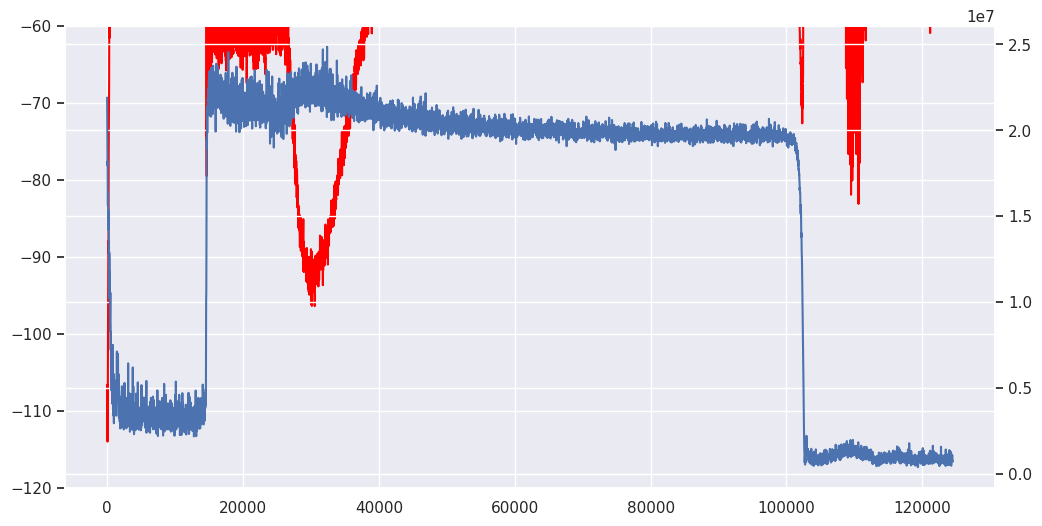

In [54]:
plt.figure(figsize=(12, 6))

plt.plot(averaging_window * np.arange(len(phi_averaged)), phi_averaged, color='red')
plt.ylim([-120, -60])
plt.twinx()
plt.plot(x := averaging_window * np.arange(len(phi_averaged), dtype='int32'), intensities[x]);

# N_av * n_a - учет усреднений для графиков 

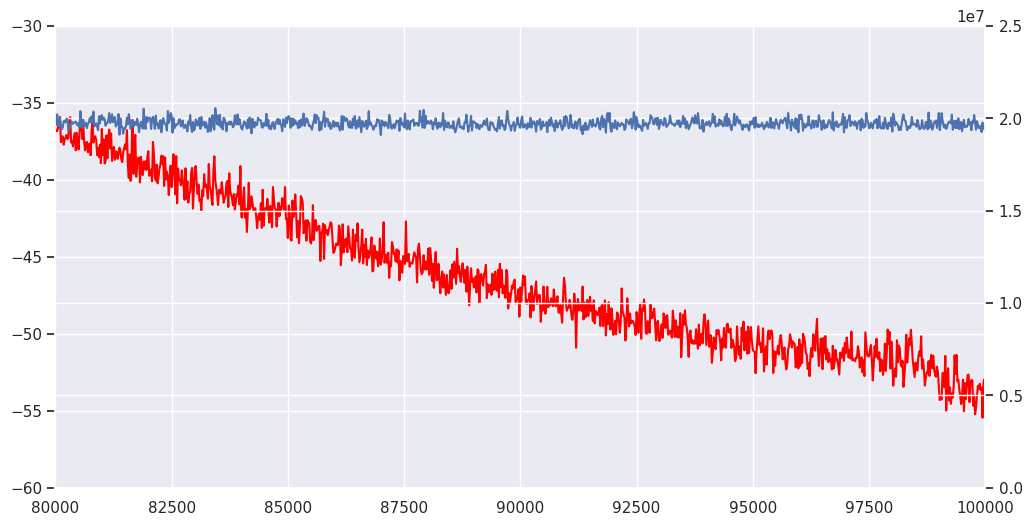

In [41]:
plt.figure(figsize=(12, 6))

plt.plot(averaging_window * np.arange(len(phi_averaged)), phi_averaged, color='red')
plt.ylim([-60, -30])
plt.xlim([8*10**4, 10**5])

plt.twinx()
plt.plot(x := averaging_window * np.arange(len(phi_averaged), dtype='int32'), intensities[x]);
plt.ylim([0, 2.5*10**7]);

# **Data writing**

In [59]:
intensities

array([21900475.95497942, 21982210.4367139 , 21219937.29384029, ...,
         587171.64490837,   751088.92106583,   712581.22066436])

In [42]:
file_name = r'BoosterAcceleration1_1half.dat'

In [43]:
O = np.dstack((correlation_matrix[2:-2,0], N_ion, fi[2:]))

NameError: name 'correlation_matrix' is not defined

In [ ]:
with open(file_name, "wb") as file:
    np.save(file, O)